TRANSFER LEARNING - FEATURE EXTRACTION

Transfer Learning is basically leveraging the architecture of an existing model and using it in our own models to make task easier and more better.

In [1]:
#are we using GPU? 
!nvidia-smi

Sun Jul  2 16:04:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 522.25       Driver Version: 522.25       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P0    15W /  N/A |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#Get the data
#This time we are getting only 10 % of the data which we used before

#import zipfile

# zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
# zip_ref.extractall()
# zip_ref.close()

In [3]:
#Inspect the data (NOTICE HOW OUR TRAIN DATA HAS ONLY 75 IMAGES AND NOT THE 750)
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in  {dirpath}")

There are 2 directories and 0 images in  10_food_classes_10_percent
There are 10 directories and 0 images in  10_food_classes_10_percent\test
There are 0 directories and 250 images in  10_food_classes_10_percent\test\chicken_curry
There are 0 directories and 250 images in  10_food_classes_10_percent\test\chicken_wings
There are 0 directories and 250 images in  10_food_classes_10_percent\test\fried_rice
There are 0 directories and 250 images in  10_food_classes_10_percent\test\grilled_salmon
There are 0 directories and 250 images in  10_food_classes_10_percent\test\hamburger
There are 0 directories and 250 images in  10_food_classes_10_percent\test\ice_cream
There are 0 directories and 250 images in  10_food_classes_10_percent\test\pizza
There are 0 directories and 250 images in  10_food_classes_10_percent\test\ramen
There are 0 directories and 250 images in  10_food_classes_10_percent\test\steak
There are 0 directories and 250 images in  10_food_classes_10_percent\test\sushi
There are 

In [4]:
#Create the Dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Hyper parameters
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("TRAIN DATA GENERATION: ")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = IMAGE_SIZE,
                                               batch_size = BATCH_SIZE,
                                               class_mode = "categorical")

print("TEST DATA GENERATION: ")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SIZE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = "categorical")


TRAIN DATA GENERATION: 
Found 750 images belonging to 10 classes.
TEST DATA GENERATION: 
Found 2500 images belonging to 10 classes.


SETTING UP CALLBACKS

Callbacks are extra functionality that we can add to our model while its running

Some of the main callbacks are:
1. Tracking experiments with Tensorboard Callback
2. Model check-pointing with ModelCheckpoint Callback
3. Stopping a model from overfitting with EarlyStopping Callback

In [5]:
#Creating a Tensorboard Callback
import datetime
import tensorflow as tf
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving the log files to {log_dir}")
    return tensorboard_callback

CREATING MODELS USING TENSORFLOW HUB

We will be using Tensorflow Hub (https://tfhub.dev/) which will give us access to a variety of models for us to choose from.

We can use this website https://paperswithcode.com/ to know about the various models in market and which one is perfoming better than another

Going through the Tensorflow Hub, we came across this model which can be helpful to our food classification model
https://tfhub.dev/google/efficientnet/b0/feature-vector/1

In [6]:
#we will be comparing two Tensorflow Hub models

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
effficient_net_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"

In [9]:
#import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [10]:
#lets create a function to make a model out of our url models

def create_model(model_url, num_classes = 10):
    """
        This function returns a model using features mentioned in the model_url model from TFHub and also takes number of classes required.
        model_url : The feature extractor model URL from TFHub
        num_classes: Number of output neurons we require in the output layer (default = 10)
    """
    #Download the model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False, #we want to maintain the model's training data and not make our own custom data
                                             name = "feature_extractor_layer",
                                             input_shape = IMAGE_SIZE + (3,) #equivalent to (224,224,3)
                                             ) 
    
    #Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(10, activation="softmax", name="ouput_layer")
    ])

    return model                                             

Creating and Testing the ResNet Model

In [12]:
resnet_model = create_model(model_url=resnet_url,
                            num_classes=train_data.num_classes)

In [14]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 ouput_layer (Dense)         (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [15]:
#Compile our model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [18]:
#Fit the model
history_resnet = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  #Adding Tensorboard callback to model
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", #save log files 
                                                                        experiment_name="resnet50V2")] #name of the log file
                                  )

Saving the log files to tensorflow_hub/resnet50V2/20230702-163500
Epoch 1/5
24/24 [==============================] - 14s 594ms/step - loss: 0.3147 - accuracy: 0.9387 - val_loss: 0.6544 - val_accuracy: 0.7828
Epoch 2/5
24/24 [==============================] - 14s 581ms/step - loss: 0.2677 - accuracy: 0.9560 - val_loss: 0.6353 - val_accuracy: 0.7892
Epoch 3/5
24/24 [==============================] - 14s 586ms/step - loss: 0.2241 - accuracy: 0.9667 - val_loss: 0.6416 - val_accuracy: 0.7840
Epoch 4/5
24/24 [==============================] - 14s 587ms/step - loss: 0.1939 - accuracy: 0.9733 - val_loss: 0.6284 - val_accuracy: 0.7880
Epoch 5/5
24/24 [==============================] - 14s 589ms/step - loss: 0.1673 - accuracy: 0.9880 - val_loss: 0.6152 - val_accuracy: 0.7920


We actually got a validation_accuracy over 75 percent!! and accuracy of around 90!!

On top of that we are only using 10 percent of the data!

It has outperformed all of the models we have made!

In [25]:
#Lets create a plot loss curves function!
import matplotlib.pyplot as plt
def plot_loss_curves(history):


    """
        This function plots loss and accuracy curves of training and validation data.
        history: Tensorflow History Object

        NOTE: Works only when metrics is ["accuracy"]
    """

    loss = history.history["loss"]
    accuracy = history.history["accuracy"]
    val_loss = history.history["val_loss"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    #plot loss curves
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs,val_loss, label="validation_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    #plot accuracy curves
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="valdiation_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

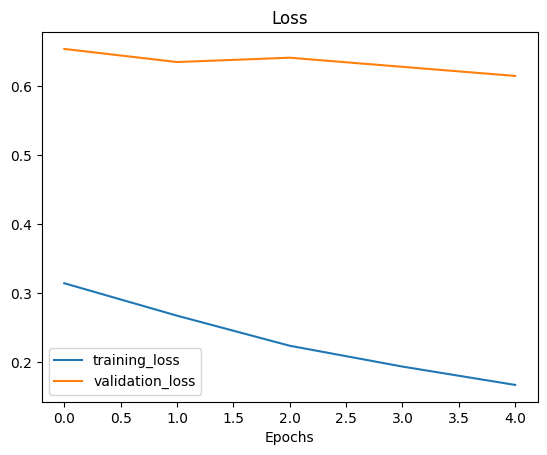

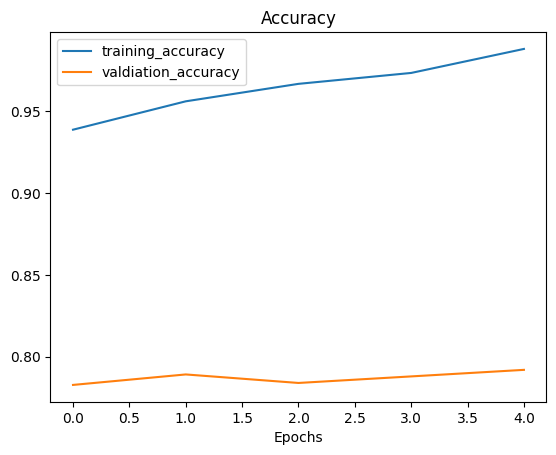

In [24]:
plot_loss_curves(history=history_resnet)

CREATING THE EFFICIENT NET B0 model

In [26]:
#Now lets create the efficient net model

efficient_net_model = create_model(model_url=effficient_net_url,
                                   num_classes=train_data.num_classes)

In [27]:
efficient_net_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 1280)             4049564   
 rasLayer)                                                       
                                                                 
 ouput_layer (Dense)         (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [28]:
#Compile the model
efficient_net_model.compile(loss="categorical_crossentropy",
                            metrics=["accuracy"],
                            optimizer=tf.keras.optimizers.Adam())

In [30]:
#Fit the model
effficient_net_history = efficient_net_model.fit(train_data,
                                                epochs=5,
                                                steps_per_epoch=len(train_data),
                                                validation_data=test_data,
                                                validation_steps=len(test_data),
                                                callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                    experiment_name="efficientNetB0")]
                                                                                    )

Saving the log files to tensorflow_hub/efficientNetB0/20230702-165719
Epoch 1/5
24/24 [==============================] - 10s 398ms/step - loss: 0.4387 - accuracy: 0.9187 - val_loss: 0.5119 - val_accuracy: 0.8728
Epoch 2/5
24/24 [==============================] - 9s 402ms/step - loss: 0.3876 - accuracy: 0.9213 - val_loss: 0.4851 - val_accuracy: 0.8764
Epoch 3/5
24/24 [==============================] - 9s 394ms/step - loss: 0.3466 - accuracy: 0.9307 - val_loss: 0.4652 - val_accuracy: 0.8784
Epoch 4/5
24/24 [==============================] - 9s 395ms/step - loss: 0.3130 - accuracy: 0.9400 - val_loss: 0.4517 - val_accuracy: 0.8792
Epoch 5/5
24/24 [==============================] - 9s 389ms/step - loss: 0.2819 - accuracy: 0.9520 - val_loss: 0.4386 - val_accuracy: 0.8784


Wow! This looks even better than ResNet! Lets plot the curves!

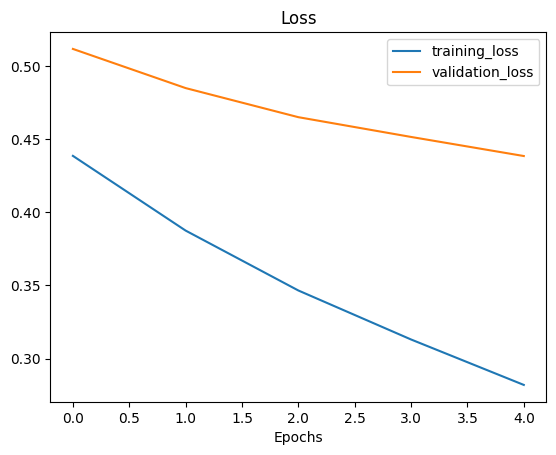

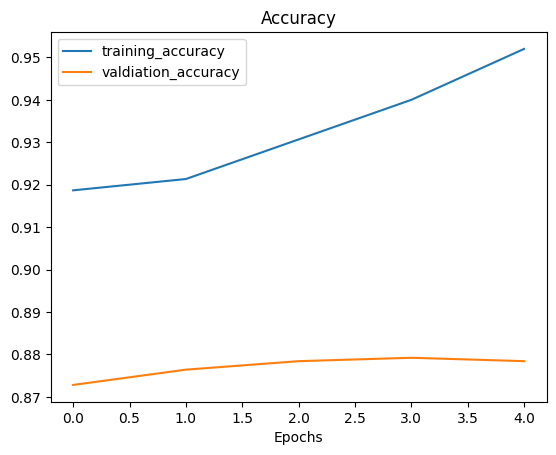

In [31]:
plot_loss_curves(effficient_net_history)

Different Types of Transfer Learning

1. **As is** - using existing model with no changes (eg Using 1000 ImageNet classes, none of our own)
2. **Transfer Learning** - use the prelearned patterns of an existing model and adjust the out put layer to our own need (eg 1000 layers -> 10 layers)

3. **Fine Tuning** - fine tune or modify the layers of an existing model (including the output layer)

COMPARE OUR MODELS TRAINING RESULTS USING TENSORBOARD!

!tensorboard dev upload --logdir ./tensorflow_hub/ \
   --name "EfficientNetB0 vs. ResNet50V2" \
   --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
   --one_shot

Write this code in terminal to upload, other wise if in VSCode, we can directly open Tensorboard with CTRL+Shift+P to open up the command palette and then write Launch Tensorboard